## Pasos a seguir:
1. Limpieza de datos: 
         1.1 Por cada archivo chequear: columnas y filas.
         1.2 Chequear nulos.
2. Transformaciones:
        2.1 Juntar todos los archivos en un solo dataframe.
        2.2 Chequear duplicados.
        2.3 Crear dummies:
                2.3.1 Momento de la semana: 7 dias divididos en 6 compartimentos de 4 horas = 42 dummies. Luego de crear los dummies removemos 1 para evitar colinearidad.
                2.3.2 Crear la variable engagement (0 o 1).
3. Balancear clases:
        3.1 La prediccion debe dar como resultado 0 o 1 y no debo tener mas ceros que unos, entonces debo balancear la clase para poder procesar. Eliminar los ceros que sobran.
4. Ejecutar regresiones logisticas usando las dummies
5. De acuerdo a eso buscar modelos mas sofisticados

    

## Initialization

In [1]:
#Data structure objects
import pandas as pd
import numpy as np

#Plotting objects
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Data splitting, scaling, transformation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

#Regressions and classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

#Evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


#Other
import warnings
import time
import math

warnings.filterwarnings('ignore')

In [2]:
#original columns
source_columns = ['campaignId', 'scheduleddate', 'campaignName','campaignSubject', 'subscriberEmail', 'cuit', 'deliveryStatus','lastOpenDate', 'opensCount', 'clicksCount']
#columns used for the first cleaning
cleaning_columns = ['campaignId', 'scheduleddate', 'campaignName',
       'campaignSubject', 'subscriberEmail', 'cuit', 'deliveryStatus',
       'lastOpenDate', 'opensCount', 'clicksCount']


#will remove the hollidays from the analysis to avoid bias.
holidays = []

def valid_file(df,cols):
    return(len(set(cols).intersection(df.columns))<=len(df.columns))

def append_data(dfappend, csv_file,source_columns,sep=''):
    df_sendings_source = pd.DataFrame()
    
    if(sep==''):
        df_sendings_source = pd.read_csv(csv_file)
    else:
        df_sendings_source = pd.read_csv(csv_file, sep)            
    df_sendings_source = df_sendings_source.reset_index(drop=True)
    dftmp = df_sendings_source[source_columns]
    dfappend = dfappend.append(dftmp, ignore_index=True)
    return dfappend




In [3]:
#Debug toolkit
def list_all_columns(df):
    return df.columns.tolist()

def lr_class_balance_status(df,y_field):
    positive_observations = len(df[df[y_field]==1])
    negative_observations = len(df[df[y_field]==0])
    all_observations = len(df)
    print(f'Total number of observations: {all_observations}')
    print(f'Positive number of observations: {positive_observations}')
    print(f'Positive number of observations: {negative_observations}')
    if(positive_observations>negative_observations):
        print(f'Imbalance on more Positive number of observations: {(positive_observations/all_observations)*100}% over 100%') 
    else:
        print(f'Imbalance on more Negative number of observations: {(negative_observations/all_observations)*100}% over 100%')         
        

## 1. Data Cleaning and Merging

In [4]:
df_sendings_cleaning = pd.DataFrame(columns=cleaning_columns)

df_sendings_cleaning = append_data(df_sendings_cleaning, '201810_reportes_camp.csv',source_columns)
df_sendings_cleaning = append_data(df_sendings_cleaning, '201811_reportes_camp.csv',source_columns)
df_sendings_cleaning = append_data(df_sendings_cleaning, '201812_reportes_camp.csv',source_columns, sep=';')
df_sendings_cleaning = append_data(df_sendings_cleaning, '201901_reportes_camp.csv',source_columns)
df_sendings_cleaning = append_data(df_sendings_cleaning, '201902_reportes_camp.csv',source_columns)

df_sendings_cleaning.count()

campaignId         2119479
scheduleddate      2119479
campaignName       2119479
campaignSubject    1088359
subscriberEmail    2119479
cuit               1990886
deliveryStatus     2119479
lastOpenDate        652707
opensCount         2119479
clicksCount        2119479
dtype: int64

In [5]:
df_sendings_cleaning.shape

(2119479, 10)

In [6]:
#drop company id with nulls
df_sendings_cleaning.dropna(subset=['cuit'], inplace=True)
df_sendings_cleaning.shape

(1990886, 10)

In [7]:
#remove duplicates
df_sendings_cleaning.drop_duplicates(inplace=True)
df_sendings_cleaning.shape

(1887933, 10)

In [8]:
#transform the company id from number to string and remove the decimal part
df_sendings_cleaning['cuit'] = df_sendings_cleaning['cuit'].astype(str, copy=False)
df_sendings_cleaning['cuit'] = df_sendings_cleaning["cuit"].str.replace(".0","") 
df_sendings_cleaning.head(5)

,campaignId,scheduleddate,campaignName,campaignSubject,subscriberEmail,cuit,deliveryStatus,lastOpenDate,opensCount,clicksCount
0,10112603,2018-10-30T20:46,20181030-Newsletter SSP,¿Qué pasó en octubre en Simplificación?,apazos@produccion.gob.ar,172557229,opened,2018-11-02T13:54,3,0
1,10112603,2018-10-30T20:46,20181030-Newsletter SSP,¿Qué pasó en octubre en Simplificación?,ericbrianworm@gmail.com,325319535,opened,2018-11-02T13:45,5,1
3,10112603,2018-10-30T20:46,20181030-Newsletter SSP,¿Qué pasó en octubre en Simplificación?,agambirassi.produccion@gmail.com,23357282179,opened,2018-11-02T13:20,3,0
4,10112603,2018-10-30T20:46,20181030-Newsletter SSP,¿Qué pasó en octubre en Simplificación?,mlopezmirau@gmail.com,3119484,opened,2018-11-02T12:13,1,0
5,10112603,2018-10-30T20:46,20181030-Newsletter SSP,¿Qué pasó en octubre en Simplificación?,maticairo@gmail.com,3965223,opened,2018-11-02T11:50,1,0


In [9]:
df_sendings_cleaning.drop(df_sendings_cleaning[df_sendings_cleaning['cuit']==''].index, inplace=True)
df_sendings_cleaning.shape

(1887624, 10)

In [10]:
#remove duplicates
df_sendings_cleaning.drop_duplicates(inplace=True)
df_sendings_cleaning.shape

(1887624, 10)

In [11]:
#drop hard and soft bounced
df_sendings_cleaning.drop(df_sendings_cleaning[df_sendings_cleaning['deliveryStatus']=='hardBounced'].index, inplace=True)
df_sendings_cleaning.drop(df_sendings_cleaning[df_sendings_cleaning['deliveryStatus']=='softBounced'].index, inplace=True)

df_sendings_cleaning.shape

(1747005, 10)

In [12]:
#types of the df
df_sendings_cleaning.dtypes


campaignId         object
scheduleddate      object
campaignName       object
campaignSubject    object
subscriberEmail    object
cuit               object
deliveryStatus     object
lastOpenDate       object
opensCount         object
clicksCount        object
dtype: object

In [13]:
#COMPANIES TO JOIN
#load target companies
df_companies_cleaning = pd.read_csv("201903_target_companies.csv")
df_companies_cleaning.head()

,cuit,province,lat,longit,is_employer,size,macro_sector,fast_growth,importing,exporting,is_client
0,20001082001,Buenos Aires,-34.613152,-58.377232,1,MICRO,Comercio,0,0,0,0
1,20001161408,Buenos Aires,-34.613152,-58.377232,1,MICRO,Agro,0,0,0,0
2,20002554292,Buenos Aires,-34.613152,-58.377232,1,MICRO,Comercio,0,0,0,0
3,20002578051,Buenos Aires,-34.613152,-58.377232,1,MICRO,Agro,0,0,0,0
4,20004240732,Buenos Aires,-34.613152,-58.377232,1,MICRO,Comercio,0,1,0,1


In [14]:
df_sendings_cleaning.dtypes

campaignId         object
scheduleddate      object
campaignName       object
campaignSubject    object
subscriberEmail    object
cuit               object
deliveryStatus     object
lastOpenDate       object
opensCount         object
clicksCount        object
dtype: object

In [15]:
#df_sendings_cleaning.to_csv('1.1-merged_data.csv', index=False)

In [16]:
#force company id column data type
df_sendings_cleaning['cuit'] = df_sendings_cleaning['cuit'].astype(str, copy=False)
df_companies_cleaning['cuit'] = df_companies_cleaning['cuit'].astype(str, copy=False)

dfsendings = df_sendings_cleaning.merge(df_companies_cleaning, on='cuit', how='inner')
dfsendings.head()

,campaignId,scheduleddate,campaignName,campaignSubject,subscriberEmail,cuit,deliveryStatus,lastOpenDate,opensCount,clicksCount,province,lat,longit,is_employer,size,macro_sector,fast_growth,importing,exporting,is_client
0,10111394,2018-10-30T14:27,20181016-SGR GRUPO B,Obtené un crédito para tu PyME con el aval de ...,gerencia@trendelfindelmundo.com.ar,33654196589,opened,2018-11-02T03:22,2,0,Tierra del Fuego,-53.771115,-67.726303,1,MEDIANA,Servicios,0,0,0,0
1,10100120,2018-10-24T20:35,20181023-Credito fiscal GRUPO A,Capacitá al personal de tu PyME,gerencia@trendelfindelmundo.com.ar,33654196589,notOpened,NaN,0,0,Tierra del Fuego,-53.771115,-67.726303,1,MEDIANA,Servicios,0,0,0,0
2,10089311,2018-10-16T20:30,20181016-REGISTRO PYME,Obtené tu certificado PyME y accedé a estos be...,gerencia@trendelfindelmundo.com.ar,33654196589,notOpened,NaN,0,0,Tierra del Fuego,-53.771115,-67.726303,1,MEDIANA,Servicios,0,0,0,0
3,10111394,2018-10-30T14:27,20181016-SGR GRUPO B,NaN,gerencia@trendelfindelmundo.com.ar,33654196589,opened,2018-11-02T03:22,2,0,Tierra del Fuego,-53.771115,-67.726303,1,MEDIANA,Servicios,0,0,0,0
4,10100120,2018-10-24T20:35,20181023-Credito fiscal GRUPO A,NaN,gerencia@trendelfindelmundo.com.ar,33654196589,notOpened,NaN,0,0,Tierra del Fuego,-53.771115,-67.726303,1,MEDIANA,Servicios,0,0,0,0


In [17]:
dfsendings.shape

(47443, 20)

## 2. Dummies


As we are trying to undesrtand which is the best date and time to send an email to a particular company, we need to dummify the "scheduleddate" variable and if we have engagement or not based on that. If the field "lastOpenDate" is nan then the mail was not opened, so no engagement in that case

In [18]:

timeBins = ['0to3','4to7','8to11','12to15','16to19','20to23']
dayBins = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

#generate column for sednings, initialize all with 0
for d in dayBins:
    for t in timeBins:
        dfsendings['s_'+d +'_'+t] = 0

dfsendings.head()

,campaignId,scheduleddate,campaignName,campaignSubject,subscriberEmail,cuit,deliveryStatus,lastOpenDate,opensCount,clicksCount,...,s_Saturday_8to11,s_Saturday_12to15,s_Saturday_16to19,s_Saturday_20to23,s_Sunday_0to3,s_Sunday_4to7,s_Sunday_8to11,s_Sunday_12to15,s_Sunday_16to19,s_Sunday_20to23
0,10111394,2018-10-30T14:27,20181016-SGR GRUPO B,Obtené un crédito para tu PyME con el aval de ...,gerencia@trendelfindelmundo.com.ar,33654196589,opened,2018-11-02T03:22,2,0,...,0,0,0,0,0,0,0,0,0,0
1,10100120,2018-10-24T20:35,20181023-Credito fiscal GRUPO A,Capacitá al personal de tu PyME,gerencia@trendelfindelmundo.com.ar,33654196589,notOpened,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10089311,2018-10-16T20:30,20181016-REGISTRO PYME,Obtené tu certificado PyME y accedé a estos be...,gerencia@trendelfindelmundo.com.ar,33654196589,notOpened,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10111394,2018-10-30T14:27,20181016-SGR GRUPO B,NaN,gerencia@trendelfindelmundo.com.ar,33654196589,opened,2018-11-02T03:22,2,0,...,0,0,0,0,0,0,0,0,0,0
4,10100120,2018-10-24T20:35,20181023-Credito fiscal GRUPO A,NaN,gerencia@trendelfindelmundo.com.ar,33654196589,notOpened,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
def nameOfDateTimeBinDummy(objConvert,prefix):
    vDateTime = pd.to_datetime(objConvert)
    nameOfDummy = prefix +'_'+vDateTime.day_name()+'_'+t_bin(vDateTime.hour)
    return nameOfDummy
def t_bin(t):
    return {
        0:'0to3',
        1:'0to3',
        2:'0to3',
        3:'0to3',
        4:'4to7',
        5:'4to7',
        6:'4to7',
        7:'4to7',
        8:'8to11',
        9:'8to11',
        10:'8to11',
        11:'8to11',
        12:'12to15',
        13:'12to15',
        14:'12to15',
        15:'12to15',
        16:'16to19',
        17:'16to19',
        18:'16to19',
        19:'16to19',
        20:'20to23',
        21:'20to23',
        22:'20to23',
        23:'20to23'}[t]

In [20]:
#sedningDateTime = pd.to_datetime(dfsendings['scheduleddate'][])

sedningDateTime = pd.to_datetime(dfsendings.iloc[0]['scheduleddate'])
print(sedningDateTime)
print(sedningDateTime.day_name())
print(sedningDateTime.hour)
print(nameOfDateTimeBinDummy(sedningDateTime,'s'))

2018-10-30 14:27:00
Tuesday
14
s_Tuesday_12to15


In [21]:
#update the dummies with the correct value
for i,r in dfsendings.iterrows():
    sedningDateTime = r['scheduleddate']
    #x = pd.to_datetime(sedningDateTime)
    #print(x.day_name())
    dfsendings.at[i,nameOfDateTimeBinDummy(sedningDateTime,'s')]=1

dfsendings.head()


,campaignId,scheduleddate,campaignName,campaignSubject,subscriberEmail,cuit,deliveryStatus,lastOpenDate,opensCount,clicksCount,...,s_Saturday_8to11,s_Saturday_12to15,s_Saturday_16to19,s_Saturday_20to23,s_Sunday_0to3,s_Sunday_4to7,s_Sunday_8to11,s_Sunday_12to15,s_Sunday_16to19,s_Sunday_20to23
0,10111394,2018-10-30T14:27,20181016-SGR GRUPO B,Obtené un crédito para tu PyME con el aval de ...,gerencia@trendelfindelmundo.com.ar,33654196589,opened,2018-11-02T03:22,2,0,...,0,0,0,0,0,0,0,0,0,0
1,10100120,2018-10-24T20:35,20181023-Credito fiscal GRUPO A,Capacitá al personal de tu PyME,gerencia@trendelfindelmundo.com.ar,33654196589,notOpened,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10089311,2018-10-16T20:30,20181016-REGISTRO PYME,Obtené tu certificado PyME y accedé a estos be...,gerencia@trendelfindelmundo.com.ar,33654196589,notOpened,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10111394,2018-10-30T14:27,20181016-SGR GRUPO B,NaN,gerencia@trendelfindelmundo.com.ar,33654196589,opened,2018-11-02T03:22,2,0,...,0,0,0,0,0,0,0,0,0,0
4,10100120,2018-10-24T20:35,20181023-Credito fiscal GRUPO A,NaN,gerencia@trendelfindelmundo.com.ar,33654196589,notOpened,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
#for x in dfsendings.iloc[0]:
#    print(x)
#test in this case I know 1 is in s_Tuesday_12to15

if(math.isnan(dfsendings.iloc[2]['lastOpenDate'])):
    print('si')
else:
    print('no')

si


In [23]:
#create the dummy engaged
dfsendings['engaged']=0

In [24]:
#update the dummies with the correct value
for i,r in dfsendings.iterrows():
    if(not (pd.isna(dfsendings.iloc[i]['lastOpenDate']))):
        dfsendings.at[i,'engaged']=1

dfsendings.head()


,campaignId,scheduleddate,campaignName,campaignSubject,subscriberEmail,cuit,deliveryStatus,lastOpenDate,opensCount,clicksCount,...,s_Saturday_12to15,s_Saturday_16to19,s_Saturday_20to23,s_Sunday_0to3,s_Sunday_4to7,s_Sunday_8to11,s_Sunday_12to15,s_Sunday_16to19,s_Sunday_20to23,engaged
0,10111394,2018-10-30T14:27,20181016-SGR GRUPO B,Obtené un crédito para tu PyME con el aval de ...,gerencia@trendelfindelmundo.com.ar,33654196589,opened,2018-11-02T03:22,2,0,...,0,0,0,0,0,0,0,0,0,1
1,10100120,2018-10-24T20:35,20181023-Credito fiscal GRUPO A,Capacitá al personal de tu PyME,gerencia@trendelfindelmundo.com.ar,33654196589,notOpened,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10089311,2018-10-16T20:30,20181016-REGISTRO PYME,Obtené tu certificado PyME y accedé a estos be...,gerencia@trendelfindelmundo.com.ar,33654196589,notOpened,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10111394,2018-10-30T14:27,20181016-SGR GRUPO B,NaN,gerencia@trendelfindelmundo.com.ar,33654196589,opened,2018-11-02T03:22,2,0,...,0,0,0,0,0,0,0,0,0,1
4,10100120,2018-10-24T20:35,20181023-Credito fiscal GRUPO A,NaN,gerencia@trendelfindelmundo.com.ar,33654196589,notOpened,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
#generate column for openings, initialize all with 0
for d in dayBins:
    for t in timeBins:
        dfsendings['o_'+d +'_'+t] = 0

dfsendings.head()

,campaignId,scheduleddate,campaignName,campaignSubject,subscriberEmail,cuit,deliveryStatus,lastOpenDate,opensCount,clicksCount,...,o_Saturday_8to11,o_Saturday_12to15,o_Saturday_16to19,o_Saturday_20to23,o_Sunday_0to3,o_Sunday_4to7,o_Sunday_8to11,o_Sunday_12to15,o_Sunday_16to19,o_Sunday_20to23
0,10111394,2018-10-30T14:27,20181016-SGR GRUPO B,Obtené un crédito para tu PyME con el aval de ...,gerencia@trendelfindelmundo.com.ar,33654196589,opened,2018-11-02T03:22,2,0,...,0,0,0,0,0,0,0,0,0,0
1,10100120,2018-10-24T20:35,20181023-Credito fiscal GRUPO A,Capacitá al personal de tu PyME,gerencia@trendelfindelmundo.com.ar,33654196589,notOpened,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10089311,2018-10-16T20:30,20181016-REGISTRO PYME,Obtené tu certificado PyME y accedé a estos be...,gerencia@trendelfindelmundo.com.ar,33654196589,notOpened,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10111394,2018-10-30T14:27,20181016-SGR GRUPO B,NaN,gerencia@trendelfindelmundo.com.ar,33654196589,opened,2018-11-02T03:22,2,0,...,0,0,0,0,0,0,0,0,0,0
4,10100120,2018-10-24T20:35,20181023-Credito fiscal GRUPO A,NaN,gerencia@trendelfindelmundo.com.ar,33654196589,notOpened,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
#generate column for openings, initialize all with 0
my_list=[]
for d in dayBins:
    for t in timeBins:
        my_list.append('o_'+d +'_'+t)

len(my_list)


42

In [27]:
my_list2 = list(filter(lambda s: s.startswith('o_'), dfsendings.columns))
len(my_list2)

42

In [28]:
#update the dummies with the correct value
for i,r in dfsendings.iterrows():
    openDateTime = r['lastOpenDate']
    if(not (pd.isna(dfsendings.iloc[i]['lastOpenDate']))):
        dfsendings.at[i,nameOfDateTimeBinDummy(openDateTime,'o')]=1

dfsendings.head()

,campaignId,scheduleddate,campaignName,campaignSubject,subscriberEmail,cuit,deliveryStatus,lastOpenDate,opensCount,clicksCount,...,o_Saturday_8to11,o_Saturday_12to15,o_Saturday_16to19,o_Saturday_20to23,o_Sunday_0to3,o_Sunday_4to7,o_Sunday_8to11,o_Sunday_12to15,o_Sunday_16to19,o_Sunday_20to23
0,10111394,2018-10-30T14:27,20181016-SGR GRUPO B,Obtené un crédito para tu PyME con el aval de ...,gerencia@trendelfindelmundo.com.ar,33654196589,opened,2018-11-02T03:22,2,0,...,0,0,0,0,0,0,0,0,0,0
1,10100120,2018-10-24T20:35,20181023-Credito fiscal GRUPO A,Capacitá al personal de tu PyME,gerencia@trendelfindelmundo.com.ar,33654196589,notOpened,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10089311,2018-10-16T20:30,20181016-REGISTRO PYME,Obtené tu certificado PyME y accedé a estos be...,gerencia@trendelfindelmundo.com.ar,33654196589,notOpened,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10111394,2018-10-30T14:27,20181016-SGR GRUPO B,NaN,gerencia@trendelfindelmundo.com.ar,33654196589,opened,2018-11-02T03:22,2,0,...,0,0,0,0,0,0,0,0,0,0
4,10100120,2018-10-24T20:35,20181023-Credito fiscal GRUPO A,NaN,gerencia@trendelfindelmundo.com.ar,33654196589,notOpened,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
#create more dummies from other values: province and macro_sector
dfsendings.index = range(1,len(dfsendings)+1)

dums = pd.get_dummies(dfsendings[['province', 'macro_sector']])
dfsendings = pd.concat([dfsendings,dums],axis=1)



In [30]:
list_all_columns(dfsendings)

['campaignId',
 'scheduleddate',
 'campaignName',
 'campaignSubject',
 'subscriberEmail',
 'cuit',
 'deliveryStatus',
 'lastOpenDate',
 'opensCount',
 'clicksCount',
 'province',
 'lat',
 'longit',
 'is_employer',
 'size',
 'macro_sector',
 'fast_growth',
 'importing',
 'exporting',
 'is_client',
 's_Monday_0to3',
 's_Monday_4to7',
 's_Monday_8to11',
 's_Monday_12to15',
 's_Monday_16to19',
 's_Monday_20to23',
 's_Tuesday_0to3',
 's_Tuesday_4to7',
 's_Tuesday_8to11',
 's_Tuesday_12to15',
 's_Tuesday_16to19',
 's_Tuesday_20to23',
 's_Wednesday_0to3',
 's_Wednesday_4to7',
 's_Wednesday_8to11',
 's_Wednesday_12to15',
 's_Wednesday_16to19',
 's_Wednesday_20to23',
 's_Thursday_0to3',
 's_Thursday_4to7',
 's_Thursday_8to11',
 's_Thursday_12to15',
 's_Thursday_16to19',
 's_Thursday_20to23',
 's_Friday_0to3',
 's_Friday_4to7',
 's_Friday_8to11',
 's_Friday_12to15',
 's_Friday_16to19',
 's_Friday_20to23',
 's_Saturday_0to3',
 's_Saturday_4to7',
 's_Saturday_8to11',
 's_Saturday_12to15',
 's_Satu

## 3. Regressions over sending date time to predict engagement

### First Logistic Regression: over sending date time

In [31]:
#with so many fields it's good idea to manage the list of dummy fields programatically, 
#grouping by homogeneus features
sendingDateTimeDummyList = list(filter(lambda s: s.startswith('s_'), dfsendings.columns))
openingDateTimeDummyList = list(filter(lambda s: s.startswith('o_'), dfsendings.columns))
provinceDummyList = list(filter(lambda s: s.startswith('province_'), dfsendings.columns))
otherDummyList = ['fast_growth','importing','exporting','is_client']
macroSectorDummyList = list(filter(lambda s: s.startswith('macro_sector_'), dfsendings.columns))
y_field = 'engaged'

In [32]:
#Checking the balance of the class
lr_class_balance_status(dfsendings,y_field)

Total number of observations: 47443
Positive number of observations: 16425
Positive number of observations: 31018
Imbalance on more Negative number of observations: 65.37950804122842% over 100%


### Logistic Regression with class imbalance

In [33]:
#create the variables X and y for the logistic regression
X= dfsendings[sendingDateTimeDummyList]
y= dfsendings[y_field]


# Split into training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify = y)

#Scale and Transform data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)



In [34]:
test_scores = []
train_scores = []

C = [.00000001,.0000001,.000001,.00001,.0001,.001,\
     1, 10, 100, 1000, 10000, 1000000]


for c in np.array(C) :
    print(c)
    my_regression = LogisticRegression(penalty='l2',C = c)
    my_regression.fit(X_train,y_train);
    
    train_scores.append(cross_val_score(my_regression,X_train,y_train,cv = 5));
    test_scores.append(cross_val_score(my_regression,X_test,y_test,cv = 5)); 

1e-08
1e-07
1e-06
1e-05
0.0001
0.001
1.0
10.0
100.0
1000.0
10000.0
1000000.0


In [35]:
for i in range(len(C)):
    print(f'For C={C[i]} the train score is {np.mean(train_scores[i])} and the test score is {np.mean(test_scores[i])}')


For C=1e-08 the train score is 0.6539258738802036 and the test score is 0.6594478759279235
For C=1e-07 the train score is 0.6539258738802036 and the test score is 0.6594478759279235
For C=1e-06 the train score is 0.6539258738802036 and the test score is 0.6594478759279235
For C=1e-05 the train score is 0.6539258738802036 and the test score is 0.6594478759279235
For C=0.0001 the train score is 0.653785350430353 and the test score is 0.6594478759279235
For C=0.001 the train score is 0.653785350430353 and the test score is 0.6594478759279235
For C=1 the train score is 0.6538556121552783 and the test score is 0.6594478759279235
For C=10 the train score is 0.6538556121552783 and the test score is 0.6594478759279235
For C=100 the train score is 0.6538556121552783 and the test score is 0.6594478759279235
For C=1000 the train score is 0.6538556121552783 and the test score is 0.6594478759279235
For C=10000 the train score is 0.6538556121552783 and the test score is 0.6594478759279235
For C=1000

If we take a look at the confusion matrix we can find out there is a problem: the negatives are working but the positive not

In [36]:

# Create predicted y-values for each X
y_pred = my_regression.predict(X)

# Evaluate our model
print('Accuracy score: ', my_regression.score(X, y))
print('Confusion matrix: \n', confusion_matrix(y, y_pred))


Accuracy score:  0.6537950804122842
Confusion matrix: 
 [[31018     0]
 [16425     0]]


### Logistic Regression with balanced classes

In [37]:
#now will balance the classes and run the regression again, and also remove 1 column to avoid colinearity
dfBsendings = dfsendings[dfsendings[y_field]==1]
N=len(dfBsendings)
dfBsendings = dfBsendings.append(dfsendings[dfsendings[y_field]==0].sample(n=N, random_state=50))

len(dfBsendings)

32850

In [38]:
sendingDateTimeDummyList_nc =sendingDateTimeDummyList.copy()
sendingDateTimeDummyList_nc.remove(sendingDateTimeDummyList_nc[np.random.randint(len(sendingDateTimeDummyList_nc))])

#create the variables X and y for the logistic regression
X= dfBsendings[sendingDateTimeDummyList_nc]
y= dfBsendings[y_field]


# Split into training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify = y)

#Scale and Transform data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

test_scores = []
train_scores = []

C = [.00000001,.0000001,.000001,.00001,.0001,.001,\
     1, 10, 100, 1000, 10000, 1000000]


for c in np.array(C) :
    print(c)
    my_regression = LogisticRegression(penalty='l2',C = c)
    my_regression.fit(X_train,y_train);
    
    train_scores.append(cross_val_score(my_regression,X_train,y_train,cv = 5));
    test_scores.append(cross_val_score(my_regression,X_test,y_test,cv = 5)); 


1e-08
1e-07
1e-06
1e-05
0.0001
0.001
1.0
10.0
100.0
1000.0
10000.0
1000000.0


In [39]:
for i in range(len(C)):
    print(f'For C={C[i]} the train score is {np.mean(train_scores[i])} and the test score is {np.mean(test_scores[i])}')


For C=1e-08 the train score is 0.5428918065153819 and the test score is 0.5456907102654253
For C=1e-07 the train score is 0.5428918065153819 and the test score is 0.5456907102654253
For C=1e-06 the train score is 0.5428918065153819 and the test score is 0.5456907102654253
For C=1e-05 the train score is 0.5428918065153819 and the test score is 0.5456907102654253
For C=0.0001 the train score is 0.5428918065153819 and the test score is 0.5456907102654253
For C=0.001 the train score is 0.5428918065153819 and the test score is 0.5456907102654253
For C=1 the train score is 0.5428918065153819 and the test score is 0.5456907102654253
For C=10 the train score is 0.5428918065153819 and the test score is 0.5456907102654253
For C=100 the train score is 0.5428918065153819 and the test score is 0.5456907102654253
For C=1000 the train score is 0.5428918065153819 and the test score is 0.5456907102654253
For C=10000 the train score is 0.5428918065153819 and the test score is 0.5456907102654253
For C=10

In [40]:
#I'll remove the C
my_regression = LogisticRegression(penalty='l2')
my_regression.fit(X_train,y_train);

train_scores.append(cross_val_score(my_regression,X_train,y_train,cv = 5));
test_scores.append(cross_val_score(my_regression,X_test,y_test,cv = 5)); 
# Create predicted y-values for each X
y_pred = my_regression.predict(X)

# Evaluate our model
print('Accuracy score: ', my_regression.score(X, y))
print('Confusion matrix: \n', confusion_matrix(y, y_pred))


Accuracy score:  0.5170167427701674
Confusion matrix: 
 [[ 1868 14557]
 [ 1309 15116]]


In [41]:
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)
#Accuracy
Accuracy = (tn+tp)*100/(tp+tn+fp+fn) 
print("Accuracy {:0.2f}%:".format(Accuracy))
#Precision 
Precision = tp/(tp+fp) 
print("Precision {:0.2f}".format(Precision))
#Recall 
Recall = tp/(tp+fn) 
print("Recall {:0.2f}".format(Recall))

True Negatives:  1868
False Positives:  14557
False Negatives:  1309
True Positives:  15116
Accuracy 51.70%:
Precision 0.51
Recall 0.92


### Adding more features to get better classification

In [42]:
sendingDateTimeDummyList_nc =sendingDateTimeDummyList.copy()
sendingDateTimeDummyList_nc.remove(sendingDateTimeDummyList_nc[np.random.randint(len(sendingDateTimeDummyList_nc))])


#create the variables X and y for the logistic regression
X= dfBsendings[sendingDateTimeDummyList_nc+provinceDummyList+macroSectorDummyList+otherDummyList]
y= dfBsendings[y_field]


# Split into training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify = y)

#Scale and Transform data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

test_scores = []
train_scores = []

C = [.00000001,.0000001,.000001,.00001,.0001,.001,\
     1, 10, 100, 1000, 10000, 1000000]


for c in np.array(C) :
    my_regression = LogisticRegression(penalty='l2',C = c)
    my_regression.fit(X_train,y_train);
    
    train_scores.append(cross_val_score(my_regression,X_train,y_train,cv = 5));
    test_scores.append(cross_val_score(my_regression,X_test,y_test,cv = 5)); 

for i in range(len(C)):
    print(f'For C={C[i]} the train score is {np.mean(train_scores[i])} and the test score is {np.mean(test_scores[i])}')


For C=1e-08 the train score is 0.5584167177321769 and the test score is 0.5494069339422666
For C=1e-07 the train score is 0.5584167177321769 and the test score is 0.5494069339422666
For C=1e-06 the train score is 0.5584167177321769 and the test score is 0.5493460696695946
For C=1e-05 the train score is 0.5581732050576786 and the test score is 0.5506248309868791
For C=0.0001 the train score is 0.5606692888955594 and the test score is 0.5511724981717514
For C=0.001 the train score is 0.5613392035998324 and the test score is 0.5494670753094546
For C=1 the train score is 0.56170477844666 and the test score is 0.5506839344849398
For C=10 the train score is 0.56170477844666 and the test score is 0.5506839344849398
For C=100 the train score is 0.56170477844666 and the test score is 0.5506839344849398
For C=1000 the train score is 0.56170477844666 and the test score is 0.5506839344849398
For C=10000 the train score is 0.56170477844666 and the test score is 0.5506839344849398
For C=1000000 the 

In [43]:
sendingDateTimeDummyList_nc =sendingDateTimeDummyList.copy()
sendingDateTimeDummyList_nc.remove(sendingDateTimeDummyList_nc[np.random.randint(len(sendingDateTimeDummyList_nc))])


#create the variables X and y for the logistic regression
X= dfBsendings[sendingDateTimeDummyList_nc+provinceDummyList+macroSectorDummyList+otherDummyList]
y= dfBsendings[y_field]


# Split into training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify = y)

#Scale and Transform data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


C=1e-05
my_regression = LogisticRegression(penalty='l2',C = c)
my_regression.fit(X_train,y_train);
test_scores = []
train_scores = []

train_scores.append(cross_val_score(my_regression,X_train,y_train,cv = 5));
test_scores.append(cross_val_score(my_regression,X_test,y_test,cv = 5));
y_pred = my_regression.predict(X)
print(f'For C={C} the train score is {np.mean(train_scores[0])} and the test score is {np.mean(test_scores[0])}')

tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)
#Accuracy
Accuracy = (tn+tp)*100/(tp+tn+fp+fn) 
print("Accuracy {:0.2f}%:".format(Accuracy))
#Precision 
Precision = tp/(tp+fp) 
print("Precision {:0.2f}".format(Precision))
#Recall 
Recall = tp/(tp+fn) 
print("Recall {:0.2f}".format(Recall))


For C=1e-05 the train score is 0.5551294726869838 and the test score is 0.5526943644812201
True Negatives:  6694
False Positives:  9731
False Negatives:  5007
True Positives:  11418
Accuracy 55.14%:
Precision 0.54
Recall 0.70


In [44]:
sendingDateTimeDummyList_nc =sendingDateTimeDummyList.copy()
sendingDateTimeDummyList_nc.remove(sendingDateTimeDummyList_nc[np.random.randint(len(sendingDateTimeDummyList_nc))])

DummyGroup = [sendingDateTimeDummyList_nc,provinceDummyList,macroSectorDummyList,otherDummyList]

for iDms in range(len(DummyGroup)):
    
    print(f'-------------------Group Dummies {iDms}------------------------')
    
    print(f'Dummies:')

    print(DummyGroup[iDms])
    
    #create the variables X and y for the logistic regression
    X= dfBsendings[DummyGroup[iDms]]
    y= dfBsendings[y_field]


    # Split into training & test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify = y)

    #Scale and Transform data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    test_scores = []
    train_scores = []

    C = [.00000001,.0000001,.000001,.00001,.0001,.001,\
         1, 10, 100, 1000, 10000, 1000000]


    for c in np.array(C) :
        print(f'C={c}, penalty l2')
        my_regression = LogisticRegression(penalty='l2',C = c)
        my_regression.fit(X_train,y_train);

        train_score= cross_val_score(my_regression,X_train,y_train,cv = 5);
        test_score=cross_val_score(my_regression,X_test,y_test,cv = 5); 

        print(f'For C={c} the train score is {np.mean(train_score)} and the test score is {np.mean(test_score)}')
        y_pred = my_regression.predict(X)
        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
        print("True Negatives: ",tn)
        print("False Positives: ",fp)
        print("False Negatives: ",fn)
        print("True Positives: ",tp)
        #Accuracy
        Accuracy = (tn+tp)*100/(tp+tn+fp+fn) 
        print("Accuracy {:0.2f}%:".format(Accuracy))
        #Precision 
        Precision = tp/(tp+fp) 
        print("Precision {:0.2f}".format(Precision))
        #Recall 
        Recall = tp/(tp+fn) 
        print("Recall {:0.2f}".format(Recall))
        
    print(f'-------------------END Group Dummies {iDms}------------------------')    
        
    

-------------------Group Dummies 0------------------------
Dummies:
['s_Monday_0to3', 's_Monday_4to7', 's_Monday_8to11', 's_Monday_12to15', 's_Monday_16to19', 's_Monday_20to23', 's_Tuesday_0to3', 's_Tuesday_4to7', 's_Tuesday_8to11', 's_Tuesday_12to15', 's_Tuesday_16to19', 's_Tuesday_20to23', 's_Wednesday_0to3', 's_Wednesday_4to7', 's_Wednesday_8to11', 's_Wednesday_12to15', 's_Wednesday_20to23', 's_Thursday_0to3', 's_Thursday_4to7', 's_Thursday_8to11', 's_Thursday_12to15', 's_Thursday_16to19', 's_Thursday_20to23', 's_Friday_0to3', 's_Friday_4to7', 's_Friday_8to11', 's_Friday_12to15', 's_Friday_16to19', 's_Friday_20to23', 's_Saturday_0to3', 's_Saturday_4to7', 's_Saturday_8to11', 's_Saturday_12to15', 's_Saturday_16to19', 's_Saturday_20to23', 's_Sunday_0to3', 's_Sunday_4to7', 's_Sunday_8to11', 's_Sunday_12to15', 's_Sunday_16to19', 's_Sunday_20to23']
C=1e-08, penalty l2
For C=1e-08 the train score is 0.5472741823825406 and the test score is 0.5389948804906941
True Negatives:  13034
False Po

For C=1e-06 the train score is 0.5137295542340533 and the test score is 0.5114781880071753
True Negatives:  5821
False Positives:  10604
False Negatives:  5433
True Positives:  10992
Accuracy 51.18%:
Precision 0.51
Recall 0.67
C=1e-05, penalty l2
For C=1e-05 the train score is 0.5137295542340533 and the test score is 0.5114781880071753
True Negatives:  5821
False Positives:  10604
False Negatives:  5433
True Positives:  10992
Accuracy 51.18%:
Precision 0.51
Recall 0.67
C=0.0001, penalty l2
For C=0.0001 the train score is 0.5137295542340533 and the test score is 0.5114781880071753
True Negatives:  5821
False Positives:  10604
False Negatives:  5433
True Positives:  10992
Accuracy 51.18%:
Precision 0.51
Recall 0.67
C=0.001, penalty l2
For C=0.001 the train score is 0.5137295542340533 and the test score is 0.5114781880071753
True Negatives:  5821
False Positives:  10604
False Negatives:  5433
True Positives:  10992
Accuracy 51.18%:
Precision 0.51
Recall 0.67
C=1.0, penalty l2
For C=1.0 th

So the best score that we have is with all the dummies but the open date (because we don't have that for all the data in the dataframe) <br>
<code>X= dfBsendings[sendingDateTimeDummyList_nc+provinceDummyList+macroSectorDummyList+otherDummyList]</code>

* For C=1e-05 the train score is 0.5540336192077773 and the test score is 0.5525122349970316
* True Negatives:  1565
* False Positives:  14860
* False Negatives:  845
* True Positives:  15580
* Accuracy 52.19%:
* Precision 0.51
* Recall 0.95

Tareas:
2. hacer un decision tree usando como label engaged y ver el resultado, ver si es mejor que la logistic regression

Segunda Clasificacion: HORARIO DE APERTURA
1. Tomar los 42 labels del opening d/t y los 16k abiertos
2. hacer un decision tree que clasifique

X = todas mis variables dummies (o ir probando, arrancar con las provincias y los opening dates)
Y = es el dia-hora en el que efectivamente se abrio el correo (usare el nombre de la columna  opening d/t en la que fue abierto el correo para cada caso)




### Using Decision Trees

For  1 as Max Depth
The TRAIN classification accuracy is:  0.5167732115677321
The TEST classification accuracy is:  0.5014307458143075

True Negatives:  16182
False Positives:  243
False Negatives:  15883
True Positives:  542
Accuracy 50.91%:
Precision 0.69
Recall 0.03
For  2 as Max Depth
The TRAIN classification accuracy is:  0.5260273972602739
The TEST classification accuracy is:  0.5115981735159817

True Negatives:  15895
False Positives:  530
False Negatives:  15277
True Positives:  1148
Accuracy 51.88%:
Precision 0.68
Recall 0.07
For  3 as Max Depth
The TRAIN classification accuracy is:  0.5410045662100457
The TEST classification accuracy is:  0.5274885844748859

True Negatives:  12125
False Positives:  4300
False Negatives:  11000
True Positives:  5425
Accuracy 53.42%:
Precision 0.56
Recall 0.33
For  4 as Max Depth
The TRAIN classification accuracy is:  0.5415525114155251
The TEST classification accuracy is:  0.5275494672754947

True Negatives:  12151
False Positives:  4274
False

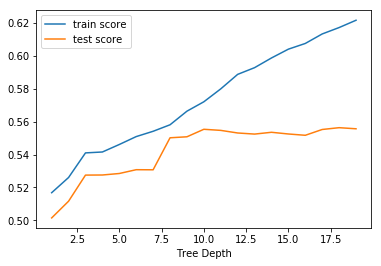

In [45]:

# NOTE: I do not remove sending datetime random column for DTs
#sendingDateTimeDummyList_nc =sendingDateTimeDummyList.copy()
#sendingDateTimeDummyList_nc.remove(sendingDateTimeDummyList_nc[np.random.randint(len(sendingDateTimeDummyList_nc))])


#create the variables X and y for the logistic regression
X= dfBsendings[sendingDateTimeDummyList+provinceDummyList+macroSectorDummyList+otherDummyList]
y= dfBsendings[y_field]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

depths = []
train_accuracies = []
test_accuracies = []

for i in range(1, 20):
    DT_model = DecisionTreeClassifier(max_depth=i, random_state=1)
    DT_model.fit(X_train, y_train)

    test_acc_score = DT_model.score(X_test, y_test)
    train_acc_score = DT_model.score(X_train, y_train)
    y_pred = DT_model.predict(X)
    
    print(f"For  {i} as Max Depth")
    print(f"The TRAIN classification accuracy is:  {DT_model.score(X_train,y_train)}")
    print(f"The TEST classification accuracy is:  {DT_model.score(X_test,y_test)}")
    print("")
    
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    print("True Negatives: ",tn)
    print("False Positives: ",fp)
    print("False Negatives: ",fn)
    print("True Positives: ",tp)
    #Accuracy
    Accuracy = (tn+tp)*100/(tp+tn+fp+fn) 
    print("Accuracy {:0.2f}%:".format(Accuracy))
    #Precision 
    Precision = tp/(tp+fp) 
    print("Precision {:0.2f}".format(Precision))
    #Recall 
    Recall = tp/(tp+fn) 
    print("Recall {:0.2f}".format(Recall))
    print(f"============================================")    
    train_accuracies.append(train_acc_score)
    test_accuracies.append(test_acc_score)
    
    depths.append(i)

    
plt.plot(depths, train_accuracies, label="train score")
plt.plot(depths, test_accuracies, label="test score")
plt.xlabel("Tree Depth")
plt.xlabel
plt.legend()
plt.show()



In [46]:
print(train_accuracies)

[0.5167732115677321, 0.5260273972602739, 0.5410045662100457, 0.5415525114155251, 0.5461187214611872, 0.5509284627092846, 0.5541552511415525, 0.5581126331811264, 0.5663926940639269, 0.5721156773211568, 0.5799695585996956, 0.5887975646879756, 0.5928767123287672, 0.5987823439878235, 0.6041400304414003, 0.6076103500761035, 0.6133942161339422, 0.6172907153729071, 0.6217351598173516]


In [47]:
print(test_accuracies)

[0.5014307458143075, 0.5115981735159817, 0.5274885844748859, 0.5275494672754947, 0.5284627092846271, 0.5307762557077625, 0.5307153729071538, 0.5501978691019787, 0.550806697108067, 0.5553729071537291, 0.5547031963470319, 0.5531202435312025, 0.5524505327245053, 0.5535464231354642, 0.5525114155251142, 0.5517199391171994, 0.5552511415525114, 0.5563470319634704, 0.5556773211567733]


In [48]:
#with 8 of max depth we have the best test score

def DecisionTreeWithDepthAndLeafs(p_max_depth, p_min_samples_leaf):
    #Fit to the training data
    DT_model = DecisionTreeClassifier(max_depth=p_max_depth, min_samples_leaf=p_min_samples_leaf)
    DT_model.fit(X_train, y_train)
    y_pred = DT_model.predict(X)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    print("True Negatives: ",tn)
    print("False Positives: ",fp)
    print("False Negatives: ",fn)
    print("True Positives: ",tp)
    #Accuracy
    Accuracy = (tn+tp)*100/(tp+tn+fp+fn) 
    print("Accuracy {:0.2f}%:".format(Accuracy))
    #Precision 
    Precision = tp/(tp+fp) 
    print("Precision {:0.2f}".format(Precision))
    #Recall 
    Recall = tp/(tp+fn) 
    print("Recall {:0.2f}".format(Recall))
    
    print(f"For  {p_max_depth} as Max Depth and {p_min_samples_leaf} as Min Samples of Leafs")
    print(f"The TRAIN classification accuracy is:  {DT_model.score(X_train,y_train)}")
    print(f"The TEST classification accuracy is:  {DT_model.score(X_test,y_test)}")
    print("")

#now that we know the best value for the Depth is 18,
#we can use try to improve the accuracy adjusting the number of leafs
for i in (range(1,10)):
     DecisionTreeWithDepthAndLeafs(18,i)

    

True Negatives:  9308
False Positives:  7117
False Negatives:  6457
True Positives:  9968
Accuracy 58.68%:
Precision 0.58
Recall 0.61
For  18 as Max Depth and 1 as Min Samples of Leafs
The TRAIN classification accuracy is:  0.6172907153729071
The TEST classification accuracy is:  0.5562861491628615

True Negatives:  9228
False Positives:  7197
False Negatives:  6480
True Positives:  9945
Accuracy 58.37%:
Precision 0.58
Recall 0.61
For  18 as Max Depth and 2 as Min Samples of Leafs
The TRAIN classification accuracy is:  0.6124809741248097
The TEST classification accuracy is:  0.5548249619482496

True Negatives:  9091
False Positives:  7334
False Negatives:  6360
True Positives:  10065
Accuracy 58.31%:
Precision 0.58
Recall 0.61
For  18 as Max Depth and 3 as Min Samples of Leafs
The TRAIN classification accuracy is:  0.6119939117199391
The TEST classification accuracy is:  0.5542770167427702

True Negatives:  9186
False Positives:  7239
False Negatives:  6521
True Positives:  9904
Accura

The best score for testing in DecisionTreeClassifier is 0.5612176560121765 and NO  with max_depth 
and with Logistic Regression For C=1e-05 the test score is 0.5525122349970316. It's too similar but the confusion matrix is more balanced with the DecisionTreeClassifier

## 4. Group Classification to predict the opening date and time

In [73]:
len(sendingDateTimeDummyList)

42

In [50]:
#we take only the group with open emails
dfengagedSendigns = dfsendings[dfsendings[y_field]==1]
len(dfengagedSendigns)

16425

In [51]:
len(openingDateTimeDummyList)

42

In [52]:
#create one column with the new Y containing the name of the datetime bin
dfengagedSendigns['predicted_dt']=''

#update the dummies with the correct value
for i,r in dfengagedSendigns.iterrows():
    done = False
    iColumn=0
    while(not done):
#            if(dfengagedSendigns.at[i,openingDateTimeDummyList[iColumn]]==1):
        if(r[openingDateTimeDummyList[iColumn]]==1):
            dfengagedSendigns.at[i,'predicted_dt']=openingDateTimeDummyList[iColumn]
            done = True
        else:
            iColumn+=1



019-06-05 -> Conversado con Sophie

Ella dice que debo observar los resultados en el contexto de la probabilidad:
    Tengo 42 espacios de day time. Si hago 1/42 = 0,0238. Esto seria equivalente a mandar el mail en cualquier momento que se me ocurra. Pero aqui vemos que si corremos este algoritmo con 23 maxdepth, tengo entre 3 y 4 veces mas posibilidades de acertar, en este caso The TEST classification accuracy is:  0.1021675596687774 con 23 maxdepth

* Achicar los bins para que haya mejor performance
* probar regularization, penalty, revisar los hiperparametros
* trabajar con los leafs
* tratar de entender la confusion matrix como hablamos: todo lo que no esta en la diagonal del True Positive es una confusion y el cruce de la confusion es LABEL A CONFUNDIDO CON LABEL B por ejemplo. Recordar que en el eje de las Y esta las reales y en el eje de las X estan las predichas.

Despues trabajar con bagging and boosting


For  1 as Max Depth
The TRAIN classification accuracy is:  0.09959819797881407
The TEST classification accuracy is:  0.08974671212859231

For  2 as Max Depth
The TRAIN classification accuracy is:  0.09959819797881407
The TEST classification accuracy is:  0.08974671212859231

For  3 as Max Depth
The TRAIN classification accuracy is:  0.09959819797881407
The TEST classification accuracy is:  0.08974671212859231

For  4 as Max Depth
The TRAIN classification accuracy is:  0.0965542432728601
The TEST classification accuracy is:  0.09035557720409157

For  5 as Max Depth
The TRAIN classification accuracy is:  0.09631072689638379
The TEST classification accuracy is:  0.0910862152946907

For  6 as Max Depth
The TRAIN classification accuracy is:  0.10166808717886278
The TEST classification accuracy is:  0.09254749147588895

For  7 as Max Depth
The TRAIN classification accuracy is:  0.103372701814197
The TEST classification accuracy is:  0.09400876765708718

For  8 as Max Depth
The TRAIN classifi

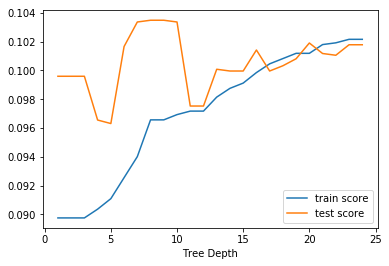

In [53]:


#create the variables X and y for the logistic regression
X= dfengagedSendigns[provinceDummyList]
y= dfengagedSendigns['predicted_dt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)


#Scale and Transform data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

depths = []
train_accuracies = []
test_accuracies = []

for i in range(1, 25):
    DT_model = DecisionTreeClassifier(max_depth=i, random_state=1)
    DT_model.fit(X_train, y_train)

    test_acc_score = DT_model.score(X_test, y_test)
    train_acc_score = DT_model.score(X_train, y_train)
    
    print(f"For  {i} as Max Depth")
    print(f"The TRAIN classification accuracy is:  {test_acc_score}")
    print(f"The TEST classification accuracy is:  {train_acc_score}")
    print("")
    print(f"============================================")    
    
    train_accuracies.append(train_acc_score)
    test_accuracies.append(test_acc_score)
    
    depths.append(i)

    
plt.plot(depths, train_accuracies, label="train score")
plt.plot(depths, test_accuracies, label="test score")
plt.xlabel("Tree Depth")
plt.xlabel
plt.legend()
plt.show()

We can not improve much with the leafs as we can see in here ..

In [54]:


def DecisionTreeWithDepthAndLeafs(p_max_depth, p_min_samples_leaf):
    #Fit to the training data
    DT_model = DecisionTreeClassifier(max_depth=p_max_depth, min_samples_leaf=p_min_samples_leaf)
    DT_model.fit(X_train, y_train)
    print(f"For  {p_max_depth} as Max Depth and {p_min_samples_leaf} as Min Samples of Leafs")
    print(f"The TRAIN classification accuracy is:  {DT_model.score(X_train,y_train)}")
    print(f"The TEST classification accuracy is:  {DT_model.score(X_test,y_test)}")
    print("")


for i in (range(10,30)):
     DecisionTreeWithDepthAndLeafs(23,i)


For  23 as Max Depth and 10 as Min Samples of Leafs
The TRAIN classification accuracy is:  0.1021675596687774
The TEST classification accuracy is:  0.10178984536710094

For  23 as Max Depth and 11 as Min Samples of Leafs
The TRAIN classification accuracy is:  0.1021675596687774
The TEST classification accuracy is:  0.10178984536710094

For  23 as Max Depth and 12 as Min Samples of Leafs
The TRAIN classification accuracy is:  0.1021675596687774
The TEST classification accuracy is:  0.10178984536710094

For  23 as Max Depth and 13 as Min Samples of Leafs
The TRAIN classification accuracy is:  0.1021675596687774
The TEST classification accuracy is:  0.10178984536710094

For  23 as Max Depth and 14 as Min Samples of Leafs
The TRAIN classification accuracy is:  0.10204578665367754
The TEST classification accuracy is:  0.10178984536710094

For  23 as Max Depth and 15 as Min Samples of Leafs
The TRAIN classification accuracy is:  0.10204578665367754
The TEST classification accuracy is:  0.101

For  1 as Max Depth
The TRAIN classification accuracy is:  0.3096834028919523
The TEST classification accuracy is:  0.3052440772278897

For  2 as Max Depth
The TRAIN classification accuracy is:  0.34117448674170564
The TEST classification accuracy is:  0.33534271983812497

For  3 as Max Depth
The TRAIN classification accuracy is:  0.3539479785843767
The TEST classification accuracy is:  0.34474327628361856

For  4 as Max Depth
The TRAIN classification accuracy is:  0.3561822857383753
The TEST classification accuracy is:  0.3473990388668746

For  5 as Max Depth
The TRAIN classification accuracy is:  0.35837443615361914
The TEST classification accuracy is:  0.34879015260096113

For  6 as Max Depth
The TRAIN classification accuracy is:  0.36115678091142867
The TEST classification accuracy is:  0.35013911137340864

For  7 as Max Depth
The TRAIN classification accuracy is:  0.3636018717592007
The TEST classification accuracy is:  0.35047635106652053

For  8 as Max Depth
The TRAIN classifica

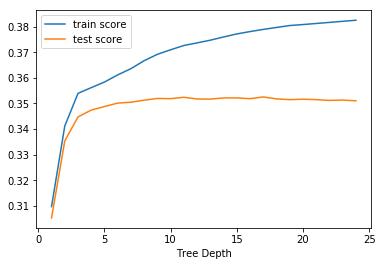

In [55]:
#Let's see if we can find out the best open time for each province putting the province as a predictor variable
dfprovinces = dfsendings[openingDateTimeDummyList+macroSectorDummyList+otherDummyList+['province']]

#create the variables X and y for the logistic regression
X= dfprovinces[openingDateTimeDummyList+macroSectorDummyList+otherDummyList]
y= dfprovinces['province']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)


#Scale and Transform data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

depths = []
train_accuracies = []
test_accuracies = []

for i in range(1, 25):
    DT_model = DecisionTreeClassifier(max_depth=i, random_state=1)
    DT_model.fit(X_train, y_train)

    test_acc_score = DT_model.score(X_test, y_test)
    train_acc_score = DT_model.score(X_train, y_train)
    
    print(f"For  {i} as Max Depth")
    print(f"The TRAIN classification accuracy is:  {train_acc_score}")
    print(f"The TEST classification accuracy is:  {test_acc_score}")
    print("")
    print(f"============================================")    
    
    train_accuracies.append(train_acc_score)
    test_accuracies.append(test_acc_score)
    
    depths.append(i)

    
plt.plot(depths, train_accuracies, label="train score")
plt.plot(depths, test_accuracies, label="test score")
plt.xlabel("Tree Depth")
plt.xlabel
plt.legend()
plt.show()



In [56]:
#Let's see if we can find out the best open time for each province putting the province as a predictor variable
dfprovinces = dfsendings[openingDateTimeDummyList+macroSectorDummyList+otherDummyList+['province']]

#create the variables X and y for the logistic regression
X= dfprovinces[openingDateTimeDummyList]
y= dfprovinces['province']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)


#Scale and Transform data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

DT_model = DecisionTreeClassifier(max_depth=23, random_state=1)
DT_model.fit(X_train, y_train)

test_acc_score = DT_model.score(X_test, y_test)
train_acc_score = DT_model.score(X_train, y_train)
    
print(f"For 23 as Max Depth")
print(f"The TRAIN classification accuracy is:  {train_acc_score}")
print(f"The TEST classification accuracy is:  {test_acc_score}")
print("")
print(f"============================================")    


For 23 as Max Depth
The TRAIN classification accuracy is:  0.3146578980650057
The TEST classification accuracy is:  0.30511761234297274



In [57]:
openingDateTimeDummyList

['o_Monday_0to3',
 'o_Monday_4to7',
 'o_Monday_8to11',
 'o_Monday_12to15',
 'o_Monday_16to19',
 'o_Monday_20to23',
 'o_Tuesday_0to3',
 'o_Tuesday_4to7',
 'o_Tuesday_8to11',
 'o_Tuesday_12to15',
 'o_Tuesday_16to19',
 'o_Tuesday_20to23',
 'o_Wednesday_0to3',
 'o_Wednesday_4to7',
 'o_Wednesday_8to11',
 'o_Wednesday_12to15',
 'o_Wednesday_16to19',
 'o_Wednesday_20to23',
 'o_Thursday_0to3',
 'o_Thursday_4to7',
 'o_Thursday_8to11',
 'o_Thursday_12to15',
 'o_Thursday_16to19',
 'o_Thursday_20to23',
 'o_Friday_0to3',
 'o_Friday_4to7',
 'o_Friday_8to11',
 'o_Friday_12to15',
 'o_Friday_16to19',
 'o_Friday_20to23',
 'o_Saturday_0to3',
 'o_Saturday_4to7',
 'o_Saturday_8to11',
 'o_Saturday_12to15',
 'o_Saturday_16to19',
 'o_Saturday_20to23',
 'o_Sunday_0to3',
 'o_Sunday_4to7',
 'o_Sunday_8to11',
 'o_Sunday_12to15',
 'o_Sunday_16to19',
 'o_Sunday_20to23']

## Thiker bins on Dummies

In [58]:
def nameOfOpenDateTimeBinDummyWider(objConvert):
    vDateTime = pd.to_datetime(objConvert)
    vDay_name = vDateTime.day_name()
    if(vDay_name =='Saturday'):
        nameOfDummy = 'wo_'+vDay_name
    elif(vDay_name =='Sunday'):
        nameOfDummy = 'wo_'+vDay_name
    else:
        try:
            nameOfDummy = 'wo_'+vDay_name+'_'+t_binWider(vDateTime.hour)
        except:
            print('objConvert: ',objConvert)
            print('vDay_name: ',vDay_name)
            print('vDateTime.hour: ',vDateTime.hour)
            raise Exception
            
    return nameOfDummy

def t_binWider(t):
    return {
        0:'morning',
        1:'morning',
        2:'morning',
        3:'morning',
        4:'morning',
        5:'morning',
        6:'morning',
        7:'morning',
        8:'morning',
        9:'morning',
        10:'morning',
        11:'morning',
        12:'morning',
        13:'afternoon',
        14:'afternoon',
        15:'afternoon',
        16:'afternoon',
        17:'afternoon',
        18:'afternoon',
        19:'afternoon',
        20:'morning',
        21:'morning',
        22:'morning',
        23:'morning'}[t]


timeBinsWider = ['morning','afternoon']
dayBinsWider = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']


In [59]:
#generate column for sednings, initialize all with 0
for d in dayBins:
    for t in timeBinsWider:
        if(d =='Saturday'):
            dfsendings['wo_'+d] = 0
        elif(d =='Sunday'):
            dfsendings['wo_'+d] = 0
        else:
            dfsendings['wo_'+d +'_'+t] = 0

dfsendings.head()


,campaignId,scheduleddate,campaignName,campaignSubject,subscriberEmail,cuit,deliveryStatus,lastOpenDate,opensCount,clicksCount,...,wo_Tuesday_morning,wo_Tuesday_afternoon,wo_Wednesday_morning,wo_Wednesday_afternoon,wo_Thursday_morning,wo_Thursday_afternoon,wo_Friday_morning,wo_Friday_afternoon,wo_Saturday,wo_Sunday
1,10111394,2018-10-30T14:27,20181016-SGR GRUPO B,Obtené un crédito para tu PyME con el aval de ...,gerencia@trendelfindelmundo.com.ar,33654196589,opened,2018-11-02T03:22,2,0,...,0,0,0,0,0,0,0,0,0,0
2,10100120,2018-10-24T20:35,20181023-Credito fiscal GRUPO A,Capacitá al personal de tu PyME,gerencia@trendelfindelmundo.com.ar,33654196589,notOpened,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10089311,2018-10-16T20:30,20181016-REGISTRO PYME,Obtené tu certificado PyME y accedé a estos be...,gerencia@trendelfindelmundo.com.ar,33654196589,notOpened,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10111394,2018-10-30T14:27,20181016-SGR GRUPO B,NaN,gerencia@trendelfindelmundo.com.ar,33654196589,opened,2018-11-02T03:22,2,0,...,0,0,0,0,0,0,0,0,0,0
5,10100120,2018-10-24T20:35,20181023-Credito fiscal GRUPO A,NaN,gerencia@trendelfindelmundo.com.ar,33654196589,notOpened,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
#update the dummies with the correct value
for i,r in dfsendings.iterrows():
    openDateTime = r['lastOpenDate']
    try:
        if(not pd.isna(openDateTime)):
            dfsendings.at[i,nameOfOpenDateTimeBinDummyWider(openDateTime)]=1
    except:
        print("pd.isna(dfsendings.iloc[i]['lastOpenDate']: ", pd.isna(dfsendings.iloc[i]['lastOpenDate']))
        print("r['lastOpenDate']:  ", r['lastOpenDate'])
        print("r:  ", r)
        break
        
dfsendings.head()

,campaignId,scheduleddate,campaignName,campaignSubject,subscriberEmail,cuit,deliveryStatus,lastOpenDate,opensCount,clicksCount,...,wo_Tuesday_morning,wo_Tuesday_afternoon,wo_Wednesday_morning,wo_Wednesday_afternoon,wo_Thursday_morning,wo_Thursday_afternoon,wo_Friday_morning,wo_Friday_afternoon,wo_Saturday,wo_Sunday
1,10111394,2018-10-30T14:27,20181016-SGR GRUPO B,Obtené un crédito para tu PyME con el aval de ...,gerencia@trendelfindelmundo.com.ar,33654196589,opened,2018-11-02T03:22,2,0,...,0,0,0,0,0,0,1,0,0,0
2,10100120,2018-10-24T20:35,20181023-Credito fiscal GRUPO A,Capacitá al personal de tu PyME,gerencia@trendelfindelmundo.com.ar,33654196589,notOpened,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10089311,2018-10-16T20:30,20181016-REGISTRO PYME,Obtené tu certificado PyME y accedé a estos be...,gerencia@trendelfindelmundo.com.ar,33654196589,notOpened,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10111394,2018-10-30T14:27,20181016-SGR GRUPO B,NaN,gerencia@trendelfindelmundo.com.ar,33654196589,opened,2018-11-02T03:22,2,0,...,0,0,0,0,0,0,1,0,0,0
5,10100120,2018-10-24T20:35,20181023-Credito fiscal GRUPO A,NaN,gerencia@trendelfindelmundo.com.ar,33654196589,notOpened,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
openingDateTimeDummyListWider = list(filter(lambda s: s.startswith('wo_'), dfsendings.columns))


In [62]:
len(openingDateTimeDummyListWider)

12

In [63]:
#we take only the group with open emails
dfengagedSendigns = dfsendings[dfsendings[y_field]==1]
len(dfengagedSendigns)


16425

In [64]:
#create one column with the new Y containing the name of the datetime bin
dfengagedSendigns['predicted_dt']=''

#update the dummies with the correct value
for i,r in dfengagedSendigns.iterrows():
    done = False
    iColumn=0
    while(not done):
#            if(dfengagedSendigns.at[i,openingDateTimeDummyList[iColumn]]==1):
        if(r[openingDateTimeDummyListWider[iColumn]]==1):
            dfengagedSendigns.at[i,'predicted_dt']=openingDateTimeDummyListWider[iColumn]
            done = True
        else:
            iColumn+=1

In [65]:
dfengagedSendigns.head()

,campaignId,scheduleddate,campaignName,campaignSubject,subscriberEmail,cuit,deliveryStatus,lastOpenDate,opensCount,clicksCount,...,wo_Tuesday_afternoon,wo_Wednesday_morning,wo_Wednesday_afternoon,wo_Thursday_morning,wo_Thursday_afternoon,wo_Friday_morning,wo_Friday_afternoon,wo_Saturday,wo_Sunday,predicted_dt
1,10111394,2018-10-30T14:27,20181016-SGR GRUPO B,Obtené un crédito para tu PyME con el aval de ...,gerencia@trendelfindelmundo.com.ar,33654196589,opened,2018-11-02T03:22,2,0,...,0,0,0,0,0,1,0,0,0,wo_Friday_morning
4,10111394,2018-10-30T14:27,20181016-SGR GRUPO B,NaN,gerencia@trendelfindelmundo.com.ar,33654196589,opened,2018-11-02T03:22,2,0,...,0,0,0,0,0,1,0,0,0,wo_Friday_morning
9,10111394,2018-10-30T14:27,20181016-SGR GRUPO B,Obtené un crédito para tu PyME con el aval de ...,sanz@ispm.edu.ar,33641241739,opened,2018-11-01T22:27,9,0,...,0,0,0,1,0,0,0,0,0,wo_Thursday_morning
10,10111394,2018-10-30T14:27,20181016-SGR GRUPO B,Obtené un crédito para tu PyME con el aval de ...,info@ispm.edu.ar,33641241739,opened,2018-10-30T18:01,1,0,...,1,0,0,0,0,0,0,0,0,wo_Tuesday_afternoon
11,10100120,2018-10-24T20:35,20181023-Credito fiscal GRUPO A,Capacitá al personal de tu PyME,info@ispm.edu.ar,33641241739,opened,2018-10-25T12:30,4,1,...,0,0,0,1,0,0,0,0,0,wo_Thursday_morning


Best score: For  29 as Max Depth
The TRAIN classification accuracy is:  0.1483014732740777
The TEST classification accuracy is:  0.21127618119824648

For  1 as Max Depth
The TRAIN classification accuracy is:  0.13443740867023868
The TEST classification accuracy is:  0.12808961402654329

For  2 as Max Depth
The TRAIN classification accuracy is:  0.1417437895762299
The TEST classification accuracy is:  0.13405576525021307

For  3 as Max Depth
The TRAIN classification accuracy is:  0.14564052605942523
The TEST classification accuracy is:  0.1360038962620236

For  4 as Max Depth
The TRAIN classification accuracy is:  0.1505114466634194
The TEST classification accuracy is:  0.13856081821502497

For  5 as Max Depth
The TRAIN classification accuracy is:  0.15379931807111544
The TEST classification accuracy is:  0.13977840009740655

For  6 as Max Depth
The TRAIN classification accuracy is:  0.1586702386751096
The TEST classification accuracy is:  0.14489224400340922

For  7 as Max Depth
The TRAIN classification accuracy is:  0.16366293229420362
The TEST classification accuracy is:  0.14623158407402898

For  8 as Max Depth
The TRAIN classifi

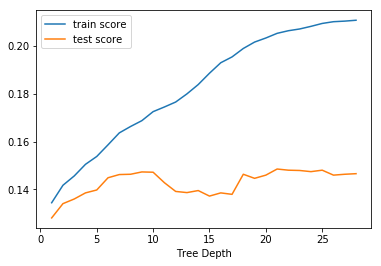

In [66]:

#create the variables X and y for the logistic regression
X= dfengagedSendigns[provinceDummyList+macroSectorDummyList+otherDummyList]
y= dfengagedSendigns['predicted_dt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)


#Scale and Transform data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

depths = []
train_accuracies = []
test_accuracies = []

for i in range(1, 29):
    DT_model = DecisionTreeClassifier(max_depth=i, random_state=1)
    DT_model.fit(X_train, y_train)

    test_acc_score = DT_model.score(X_test, y_test)
    train_acc_score = DT_model.score(X_train, y_train)
    
    print(f"For  {i} as Max Depth")
    print(f"The TRAIN classification accuracy is:  {train_acc_score}")
    print(f"The TEST classification accuracy is:  {test_acc_score}")
    print("")
    print(f"============================================")    
    
    train_accuracies.append(train_acc_score)
    test_accuracies.append(test_acc_score)
    
    depths.append(i)

    
plt.plot(depths, train_accuracies, label="train score")
plt.plot(depths, test_accuracies, label="test score")
plt.xlabel("Tree Depth")
plt.xlabel
plt.legend()
plt.show()

Lo que hable con Mike es lo siguiente:
* Cuando hago cualquier cosa primero ESCALO X
* si la cantidad de dimensiones lo justifica, reduzco dimensionalidad con PCA
* despues hago un train test split
* luego si estoy haciendo un loop para buscar los mejores hiperparametros o regularization, usar crossvalidation
* en KNN debo loopear seteando buscando el mejor numero para el parametro n_neighbors (en este caso el crossvalidation lo hago adentro de dicho loop)
SVC
* cuando haga SVC tengo que configurar el parametro C, es decir regularization. la idea es tambien probar diferentes kernels y en caso de que usemos "poly" podemos configurar el parametro degree.




In [67]:
# NOT GOOD

# #create the variables X and y for the logistic regression
# X= dfengagedSendigns[provinceDummyList+macroSectorDummyList+otherDummyList]
# y= dfengagedSendigns['predicted_dt']


# #Scale and Transform data
# scaler = StandardScaler()
# scaler.fit(X)
# X_s = scaler.transform(X)

# X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.2, random_state=1)


# print(f"The number of data points is: {len(dfengagedSendigns)}")
# print(f"The number of data points in train for KNN is: {len(X_train)}")
# print(f"The number of data points in test for KNN is: {len(X_test)}")



# test_scores = []
# train_scores = []
# K = []

# #for i in range(1, X_test.shape[0]):
# for i in range(1, 4):
#     KNN_model = KNeighborsClassifier(n_neighbors=i)
#     KNN_model.fit(X_train, y_train)
# #     print("np.mean(cross_val_score(KNN_model,X_test,y_test,cv = 5))",np.mean(cross_val_score(KNN_model,X_test,y_test,cv = 5)));
# #     print("np.mean(cross_val_score(KNN_model,X_test,y_test,cv = 5))",np.mean(cross_val_score(KNN_model,X_test,y_test,cv = 5)));

#     #train_scores.append(np.mean(cross_val_score(KNN_model,X_train,y_train,cv = 5)));

    
#     test_scores.append(np.mean(cross_val_score(KNN_model,X_test,y_test,cv = 5)));
#     train_scores.append(np.mean(cross_val_score(KNN_model,X_train,y_train,cv = 5)));
#     K.append(i)

#     print(f"For  {i} as n_neighbors")
#     print(f"The TRAIN classification accuracy is:  {train_scores}")
#     print(f"The TEST classification accuracy is:  {test_scores}")
#     print("")
#     print(f"============================================")        
    
# plt.plot(K, test_scores, label="test")
# plt.plot(K, train_scores, label="train")
# plt.legend()
# plt.show()


In [70]:
from sklearn.svm import SVC
my_kernel_SVM = SVC()
#my_linear_kernel_SVM = SVC(kernel='linear')

X= dfengagedSendigns[provinceDummyList+macroSectorDummyList+otherDummyList]
y= dfengagedSendigns['predicted_dt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)


#Scale and Transform data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)



#Fit the data
my_kernel_SVM.fit(X_train,y_train)
#Get the score
print("TRAIN: Kernel SVM score: %3.3f" % (100*my_kernel_SVM.score(X_train,y_train)))
print("TEST: Kernel SVM score: %3.3f" % (100*my_kernel_SVM.score(X_test,y_test)))

TRAIN: Kernel SVM score: 18.887
TEST: Kernel SVM score: 15.342


In [71]:
def fitSVC(X,y,krnl,regu,p,ptest_size,rnd_state,test_scores,train_scores):
    
    msjOutput = f'=================\n'
    msjOutput = msjOutput + f'SVC parameters: \n'        
    msjOutput = msjOutput + f'kernel={krnl},C={regu},degree={p}  \n'        

    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ptest_size, random_state=rnd_state)
    
    #Scale and Transform data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)


    if(krnl=='poly'):
        my_kernel_SVM = SVC(kernel=krnl,C=regu,degree=p)
        my_kernel_SVM.fit(X_train,y_train)
        #Get the score
        #print("TRAIN: Kernel SVM score: %3.3f" % (100*my_kernel_SVM.score(X_train,y_train)))
        #print("TEST: Kernel SVM score: %3.3f" % (100*my_kernel_SVM.score(X_test,y_test)))
        train_score=np.mean(cross_val_score(my_kernel_SVM,X_train,y_train,cv = 5))
        test_score=np.mean(cross_val_score(my_kernel_SVM,X_test,y_test,cv = 5))
        msjOutput = msjOutput + f'train_score={train_score}\ntest_score={test_score}\n'        
        train_scores.append(train_score);
        test_scores.append(test_score); 
    else:            
        
        my_kernel_SVM = SVC(kernel=krnl,C=regu)
        my_kernel_SVM.fit(X_train,y_train)
        train_score=np.mean(cross_val_score(my_kernel_SVM,X_train,y_train,cv = 5))
        test_score=np.mean(cross_val_score(my_kernel_SVM,X_test,y_test,cv = 5))
        msjOutput = msjOutput + f'train_score={train_score}\ntest_score={test_score}\n'        
        train_scores.append(train_score);
        test_scores.append(test_score); 
        
    return test_scores,train_scores,msjOutput

Best for now:
SVC parameters: 
kernel=rbf,C=10,degree=nan  
train_score=0.1483143554325244
test_score=0.15158069617973094

In [ ]:

#TRYING DIFFRENT KERNELS AND REGULRARIZATIONS
SVCKernelList = ['rbf','linear', 'poly', 'sigmoid'] #rfb is default
SVCKernelPolyDegreeList = [1,2,3,4,5] # Just used with Poly Kernel. 3 is default
#REGULARIZATION
#C = [.00000001,.0000001,.000001,.00001,.0001,.001,\
#     1, 10, 100, 1000, 10000, 1000000]
C = [.0001,.001,\
     1, 10, 100,]


X= dfengagedSendigns[provinceDummyList+macroSectorDummyList+otherDummyList]
y= dfengagedSendigns['predicted_dt']
#scores
test_scores = []
train_scores = []
msj = ''

for krnl in SVCKernelList:
#    print('=================')
#    print('krnl: ', krnl)
    for regu in C:
#        print('regu: ', regu)
        if(krnl=='poly'):
            for p in SVCKernelPolyDegreeList:
                test_scores,train_scores,msj = fitSVC(X,y,krnl,regu,p,0.5,43,test_scores,train_scores)
                print(msj)
        else:
            test_scores,train_scores,msj = fitSVC(X,y,krnl,regu,np.NaN,0.5,43,test_scores,train_scores)
            print(msj)        
















# my_kernel_SVM = SVC()
# #my_linear_kernel_SVM = SVC(kernel='linear')

# X= dfengagedSendigns[provinceDummyList+macroSectorDummyList+otherDummyList]
# y= dfengagedSendigns['predicted_dt']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)


# #Scale and Transform data
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)



# #Fit the data
# my_kernel_SVM.fit(X_train,y_train)
# #Get the score
# print("TRAIN: Kernel SVM score: %3.3f" % (100*my_kernel_SVM.score(X_train,y_train)))
# print("TEST: Kernel SVM score: %3.3f" % (100*my_kernel_SVM.score(X_test,y_test)))


SVC parameters: 
kernel=rbf,C=0.0001,degree=nan  
train_score=0.12810518320942849
test_score=0.1288203551743567

SVC parameters: 
kernel=rbf,C=0.001,degree=nan  
train_score=0.12810518320942849
test_score=0.1288203551743567

SVC parameters: 
kernel=rbf,C=1,degree=nan  
train_score=0.15246172930269625
test_score=0.15133782600826667

SVC parameters: 
kernel=rbf,C=10,degree=nan  
train_score=0.1483143554325244
test_score=0.15158069617973094

SVC parameters: 
kernel=rbf,C=100,degree=nan  
train_score=0.14734222486232484
test_score=0.15024323359489852

SVC parameters: 
kernel=linear,C=0.0001,degree=nan  
train_score=0.12810518320942849
test_score=0.1288203551743567

SVC parameters: 
kernel=linear,C=0.001,degree=nan  
train_score=0.14308675036610782
test_score=0.13028904760493534

SVC parameters: 
kernel=linear,C=1,degree=nan  
train_score=0.15514938274446238
test_score=0.14016219470052507

SVC parameters: 
kernel=linear,C=10,degree=nan  
train_score=0.15502735711908106
test_score=0.14065067

In [77]:
def fun1(p1):
    p1 = 2
    return p1,4,6

r1=0
r2=0
r3=0

r1,r2,r3 = fun1(r1)

print(r1, r2, r3)


2 4 6


In [ ]:
# DONT RUN, TAKES TOO MUCH TIME AND IT'S NOT GOOD
# #x and y
# X= dfengagedSendigns[provinceDummyList+macroSectorDummyList+otherDummyList]
# y= dfengagedSendigns['predicted_dt']
# #regularizartion
# #C = [.0001,.001,\
# #     1, 10, 100,]
# regu = 1
# #scores
# test_scores = []
# train_scores = []
# #output messaje
# msj = ''

# krnl='poly'
# regu=1

# test_scores,train_scores,msj = fitSVC(X,y,krnl,regu,np.NaN,0.5,43,test_scores,train_scores)

In [72]:
#TRYING DIFFRENT KERNELS AND REGULRARIZATIONS
SVCKernelList = ['sigmoid'] #rfb is default
SVCKernelPolyDegreeList = [1,2,3,4,5] # Just used with Poly Kernel. 3 is default
#REGULARIZATION
#C = [.00000001,.0000001,.000001,.00001,.0001,.001,\
#     1, 10, 100, 1000, 10000, 1000000]
C = [1]


X= dfengagedSendigns[provinceDummyList+macroSectorDummyList+otherDummyList]
y= dfengagedSendigns['predicted_dt']
#scores
test_scores = []
train_scores = []
msj = ''

for krnl in SVCKernelList:
#    print('=================')
#    print('krnl: ', krnl)
    for regu in C:
#        print('regu: ', regu)
        if(krnl=='poly'):
            for p in SVCKernelPolyDegreeList:
                test_scores,train_scores,msj = fitSVC(X,y,krnl,regu,p,0.5,43,test_scores,train_scores)
                print(msj)
        else:
            test_scores,train_scores,msj = fitSVC(X,y,krnl,regu,np.NaN,0.5,43,test_scores,train_scores)
            print(msj)        


SVC parameters: 
kernel=sigmoid,C=1,degree=nan  
train_score=0.1486924162862227
test_score=0.13406830330467906



In [74]:
from sklearn.svm import SVC
my_kernel_SVM = SVC()
#my_linear_kernel_SVM = SVC(kernel='linear')

X= dfengagedSendigns[provinceDummyList+macroSectorDummyList+otherDummyList]
y= dfengagedSendigns['predicted_dt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)


#Scale and Transform data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)



#Fit the data
my_kernel_SVM.fit(X_train,y_train)
#Get the score
print("TRAIN: Kernel SVM score: %3.3f" % (100*my_kernel_SVM.score(X_train,y_train)))
print("TEST: Kernel SVM score: %3.3f" % (100*my_kernel_SVM.score(X_test,y_test)))

TRAIN: Kernel SVM score: 18.887
TEST: Kernel SVM score: 15.342


In [104]:
dfsendings_filtered = dfengagedSendigns[(dfengagedSendigns['province']=='Salta') & (dfengagedSendigns['macro_sector']=='Industria')]


from sklearn.svm import SVC
my_kernel_SVM = SVC()
#my_linear_kernel_SVM = SVC(kernel='linear')

X= dfsendings_filtered[macroSectorDummyList+otherDummyList]
y= dfsendings_filtered['predicted_dt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)


#Scale and Transform data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)



#Fit the data
my_kernel_SVM.fit(X_train,y_train)
predictions = my_kernel_SVM.predict(X_test) 
#Get the score
print("TRAIN: Kernel SVM score: %3.3f" % (100*my_kernel_SVM.score(X_train,y_train)))
print("TEST: Kernel SVM score: %3.3f" % (100*my_kernel_SVM.score(X_test,y_test)))



TRAIN: Kernel SVM score: 57.143
TEST: Kernel SVM score: 50.000


In [91]:
dfengagedSendigns['macro_sector'].unique()

array(['Servicios', 'Agro', 'Industria', 'Construccion', 'Comercio ',
       'Mineria'], dtype=object)

In [103]:
predictions

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [105]:


score = my_kernel_SVM.score(X_test, y_test)
cm = confusion_matrix(y_test, predictions)




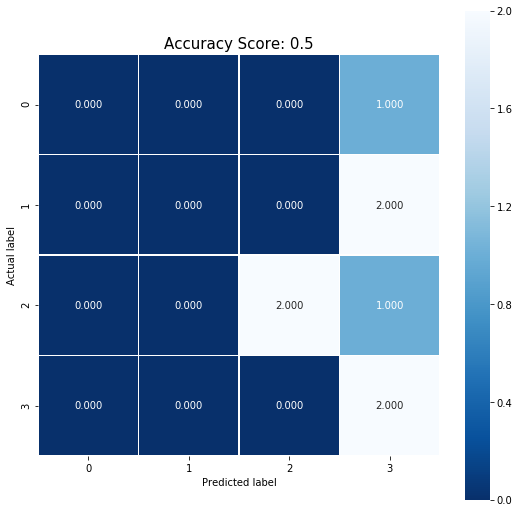

In [106]:

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);


TRAIN: Kernel SVM score: 18.887
TEST: Kernel SVM score: 15.342


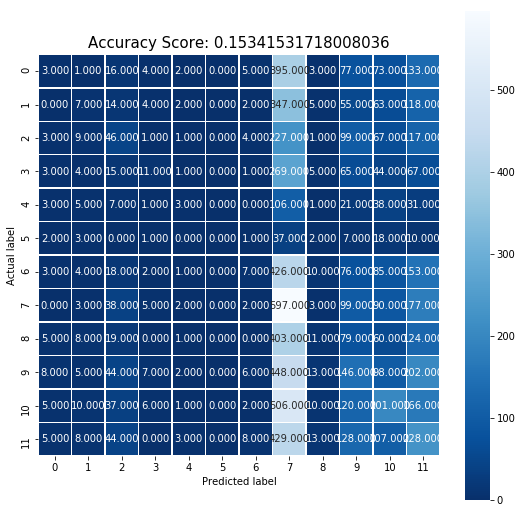

In [107]:
from sklearn.svm import SVC
my_kernel_SVM = SVC()
#my_linear_kernel_SVM = SVC(kernel='linear')

X= dfengagedSendigns[provinceDummyList+macroSectorDummyList+otherDummyList]
y= dfengagedSendigns['predicted_dt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)


#Scale and Transform data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)



#Fit the data
my_kernel_SVM.fit(X_train,y_train)

predictions = my_kernel_SVM.predict(X_test) 

#Get the score
print("TRAIN: Kernel SVM score: %3.3f" % (100*my_kernel_SVM.score(X_train,y_train)))
print("TEST: Kernel SVM score: %3.3f" % (100*my_kernel_SVM.score(X_test,y_test)))

score = my_kernel_SVM.score(X_test, y_test)
cm = confusion_matrix(y_test, predictions)


plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

